In [251]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
import itertools

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap


#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if str.lower(str.strip(token.lemma_)) not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)

from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

wc = WordCloud()

# Data Acquisition

In [25]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)



#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])

df = df.sample(frac = 1)
# dependent and independent variable
X = df['text']
y = df['target']

df['label'].value_counts()
#_____________________________________________________________________________________________________________________________________________

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [56]:
df = df.dropna()

# Exploratory Data Analysis

In [32]:
print(df.shape)
df.head()

(11314, 3)


,text,label,target
768,\nThe oclock widget was written using the SHAP...,computer,1
2662,I have a quick question regarding the Rockwell...,computer,1
7561,\nI have the same problem. I have looked at M...,computer,1
8347,AHL CALDER CUP PLAYOFF GAME(S) PLAYED ON 4/16\...,sport,7
1412,"\nIn the case of victimless crimes yes, I thin...",politics,3


In [3]:
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

### Sample for EDA

In [212]:
df_s = df.sample(5000)
df_s['spacy_obj'] = df_s['text'].apply(lambda x:nlp(x))
df_s['label'].value_counts()

computer      1359
science        782
politics       707
automobile     576
sport          551
religion       482
medicine       283
sales          260
Name: label, dtype: int64

In [213]:
sample = df_s.sample(1)
sample

,text,label,target,tokens,richness_text,unique_text,spacy_obj
7783,"With the continuin talk about the ""End of the ...",science,6,NaN,NaN,NaN,"(With, the, continuin, talk, about, the, "", En..."


In [214]:
print(sample.text.values[0] ,sample.label)

With the continuin talk about the "End of the Space Age" and complaints 
by government over the large cost, why not try something I read about 
that might just work.

Announce that a reward of $1 billion would go to the first corporation 
who successfully keeps at least 1 person alive on the moon for a year. 
Then you'd see some of the inexpensive but not popular technologies begin 
to be developed. THere'd be a different kind of space race then!
 7783    science
Name: label, dtype: object


In [215]:
sample

,text,label,target,tokens,richness_text,unique_text,spacy_obj
7783,"With the continuin talk about the ""End of the ...",science,6,NaN,NaN,NaN,"(With, the, continuin, talk, about, the, "", En..."


In [216]:
len([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ])

78

In [217]:
len(set([token.text for token in nlp(sample.text.values[0]) if token.is_alpha ]))

62

## Example of Preprocessing

In [225]:
df_s.head()

,text,label,target,tokens,richness_text,unique_text,spacy_obj,is_alpha_pure,is_alpha_num,len_text,n_unique_text
6392,\nLook how long the Maple Leafs and Nordiques ...,sport,7,"[\n, Look, how, long, the, Maple, Leafs, and, ...",0.128319,"[Leafs, occasion, problems, humor, long, bad, ...","(\n, Look, how, long, the, Maple, Leafs, and, ...","[Look, how, long, the, Maple, Leafs, and, Nord...","[\n, ...., , \n, ,, (, \n, ), \n, ., , what-...",678,87
4842,"\n :Because of some contract, IBM is not allow...",computer,1,"[\n , :, Because, of, some, contract, ,, IBM, ...",0.142012,"[computers, least, not, I, you, any, coprocess...","(\n , :, Because, of, some, contract, ,, IBM, ...","[Because, of, some, contract, IBM, is, not, al...","[\n , :, ,, \n , :, 486, ,, \n , :, -, ., \n\n...",507,72
10380,Help!!!\n\nI have an ADB graphicsd tablet whic...,computer,1,"[Help, !, !, !, \n\n, I, have, an, ADB, graphi...",0.132450,"[my, I, tablet, Quadra, mouse, course, to, Tha...","(Help, !, !, !, \n\n, I, have, an, ADB, graphi...","[Help, I, have, an, ADB, graphicsd, tablet, wh...","[!, !, !, \n\n, \n, 950, ., ,, 950, \n, ., \n\...",302,40
1715,Hi.\n\nThe RTrace ray tracer supports 3D text ...,computer,1,"[Hi, ., \n\n, The, RTrace, ray, tracer, suppor...",0.127962,"[text, a, not, chars, you, The, extruded, so, ...","(Hi, ., \n\n, The, RTrace, ray, tracer, suppor...","[Hi, The, RTrace, ray, tracer, supports, text,...","[., \n\n, 3D, ,, \n, ,, ..., \n, 3D, ..., \n\n...",422,54
6512,[reply to geb@cs.pitt.edu (Gordon Banks)]\n \n...,medicine,2,"[[, reply, to, geb@cs.pitt.edu, (, Gordon, Ban...",0.146032,"[like, wo, my, a, I, not, waste, second, expla...","([, reply, to, geb@cs.pitt.edu, (, Gordon, Ban...","[reply, to, Gordon, Banks, I, made, a, decisio...","[[, geb@cs.pitt.edu, (, ), ], \n \n \n \n, \n,...",315,46


In [226]:
# df_s['tokens'] =
df_s['tokens'] = df_s['spacy_obj'].apply(lambda x:list(x)  )

In [223]:
df_s['is_alpha_pure'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  token.is_alpha ] )
df_s['is_alpha_num'] = df_s['tokens'].apply(lambda x: [token.text for token in x if  not token.is_alpha ] )
df_s['len_text'] = df_s['text'].apply(lambda x: len(x) )
df_s['unique_text'] = df_s['is_alpha_pure'].apply(lambda x: list(set(x)) ) 
df_s['n_unique_text'] = df_s['is_alpha_pure'].apply(lambda x:len( set(x) ) )
df_s['richness_text'] = df_s['n_unique_text']/df_s['len_text'] 

<AxesSubplot:>

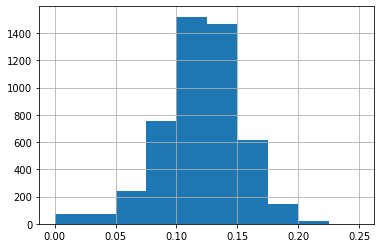

In [227]:
df_s['richness_text'].hist()

In [228]:
from itertools import chain
group_class_docs = df_s.groupby('label')['unique_text'].apply(list) 
group_class_uniqe_texts = group_class_docs.apply(lambda x : list(itertools.chain(*x)))
group_class_uniqe_texts.apply(lambda x:len(x)) 
grouped_vocabolary = group_class_uniqe_texts.apply(lambda x:str(' '.join(x)))

In [229]:
grouped_vocabolary

label
automobile    blasphemy looks not long sob address so of and...
computer      computers least not I you any coprocessor espe...
medicine      like wo my a I not waste second explanation MR...
politics      On dismissed other a jointly land you survivor...
religion      getaway not yet held by something Oh trying ma...
sales         from Chicago tuesday about wanted Indi days on...
science       half speech turn agents a might attack pointle...
sport         Leafs occasion problems humor long bad logic s...
Name: unique_text, dtype: object

In [253]:
def word_freq(label): return pd.Series([ t.lemma_ for t in nlp(grouped_vocabolary[label]) if str.lower(str.strip(t.lemma_)) not in stopwords.words('english')  ] ).value_counts()

In [259]:
grouped_vocabolary

label
automobile    blasphemy looks not long sob address so of and...
computer      computers least not I you any coprocessor espe...
medicine      like wo my a I not waste second explanation MR...
politics      On dismissed other a jointly land you survivor...
religion      getaway not yet held by something Oh trying ma...
sales         from Chicago tuesday about wanted Indi days on...
science       half speech turn agents a might attack pointle...
sport         Leafs occasion problems humor long bad logic s...
Name: unique_text, dtype: object

In [265]:
vocabulary_len_category = dict({ k:len(word_freq(k).index.to_list()) for k in grouped_vocabolary.index.to_list() } )

## We decide the size of sparse matrix tfidf based on the median of the vocabs per category

In [280]:
pd.Series(vocabulary_len_category).sort_values().describe()#  be aware that the smaple might be biased 

count        8.000000
mean      9465.750000
std       3421.168587
min       5043.000000
25%       6993.000000
50%       8475.500000
75%      13166.000000
max      13596.000000
dtype: float64

# Preprocessing Pipeline

In [ ]:
# doc  = nlp('I  @  1223 am happy for your new promotion')
# tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
# filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
# filter_token_sw

In [5]:
# Proportions of labels
pd.DataFrame(y.value_counts()).T

,2,6,3,1,7,0,4,5
target,585,585,585,585,585,585,585,585


### Downsampling Data

In [4]:
def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

df_balanced = downsample(df)
# dependent and independent variable
X = df_balanced['text']
y = df_balanced['target']

In [6]:


    
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)



class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    

    

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 20,dtype=int )

In [7]:
X.shape

(4680,)

# Model Pipeline

### Hyperparameters fine-tuning

In [281]:
# TF IDF DIMENSION will affect the model 
matrix_features  = 8000 # approximation of the len of vocabolary per each category

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model

#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'kc__epochs': [20,30,50],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}


#StratifiedKFold(n_splits=2, shuffle=True)



In [282]:
model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True,max_features=matrix_features)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=skf.split(X,y),
                    param_grid=param_grid,
                    scoring='accuracy')

C:\Users\david\AppData\Local\Temp/ipykernel_12480/3753903976.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


In [283]:
from sklearn import set_config
set_config(display='diagram')

grid

GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002AB703F8270>,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=8000)),
                                       ('sparse_to_dense',
                                        <__main__.DenseTransformer object at 0x000002AB703E67C0>),
                                       ('scaler', MaxAbsScaler()),
                                       ('kc',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002AB703E6C70>)]),
             param_grid={'kc__batch_size': [16, 32, 50],
                         'kc__dropout': [0.3, 0.1, 0],
                         'kc__epochs': [20, 30, 50],
                         'kc__neurons': [10, 20, 30, 100],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

#### Grid Search 

In [284]:
# limit = 100
# X_p = prep_pipeline.fit_transform(X[:limit]).toarray()
# X_p.shape

In [285]:
# from sklearn.utils.multiclass import type_of_target
# type_of_target(y) , type_of_target(yc)

In [287]:
X_t = prep_pipeline.fit_transform(X)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {round(delta,3)}')
results.head()

Fitting 3 folds for each of 216 candidates, totalling 648 fits


## Fit the Pipeline

In [ ]:
# TEST SAMPLE
# limit = 1000

# model = create_model(neurons=20)
# model.summary()

In [ ]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X,y)
time.time() - t0 

# Testing Pipeline

In [ ]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])

# drop non in categories
df = df.loc[df['label'].isin(key_categories)]
#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

In [ ]:
X_test_prep = prep_pipeline.transform(X_test)

In [ ]:
y_pred  = opt_pipeline.predict(X_test_prep)
print(classification_report(y_test,y_pred))

In [ ]:
dist_proba_pred = pd.DataFrame(fitted_pipe.predict_proba(X_test_prep), columns=key_categories)

dist_proba_pred.hist(figsize = (10,8));

In [ ]:
df['label'].unique()

In [ ]:
def make_custom_predictions(fitted_pipe = fitted_pipe):return label_encoder.inverse_transform(fitted_pipe.predict(pd.Series(input('Input-Text:'))))

In [ ]:
make_custom_predictions()

In [ ]:
def save_keras_pipe(pipeline):
    # Save the Keras model first:
    pipeline.named_steps['kc'].model.save('keras_model.h5')

    # This hack allows us to save the sklearn pipeline:
    pipeline.named_steps['kc'].model = None

    # Finally, save the pipeline:
    joblib.dump(pipeline, 'sklearn_pipeline.pkl')

In [ ]:
save_keras_pipe(fitted_pipe)

# Load the trained model 

In [15]:
from keras.models import load_model
import joblib
# Load the pipeline first:
pipeline = joblib.load('sklearn_pipeline.pkl')

# Then, load the Keras model:
pipeline.named_steps['kc'].model = load_model('keras_model.h5')


              precision    recall  f1-score   support

    computer       0.66      0.67      0.67       794
       sport       0.85      0.71      0.78      1955
    politics       0.58      0.63      0.61       396
  automobile       0.73      0.63      0.68      1050
     science       0.69      0.71      0.70       649
    medicine       0.42      0.78      0.55       390
    religion       0.66      0.53      0.59      1183
       sales       0.62      0.86      0.72       796

    accuracy                           0.68      7213
   macro avg       0.65      0.69      0.66      7213
weighted avg       0.70      0.68      0.68      7213

Confusion matrix, without normalization


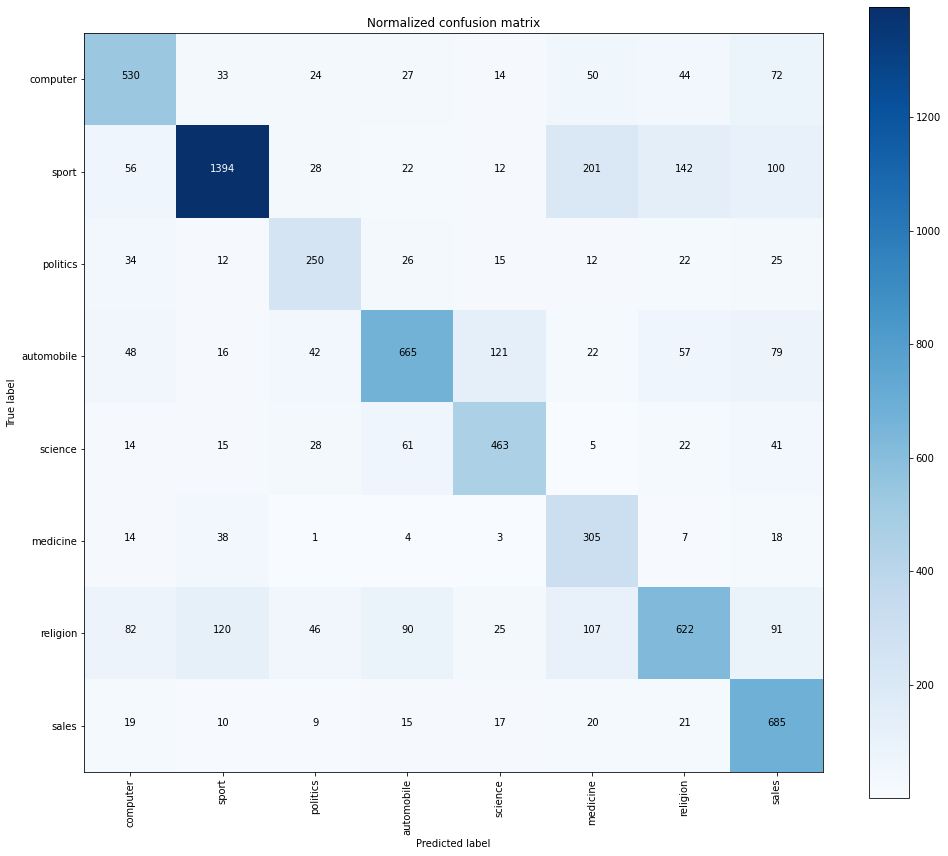

In [183]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

y_pred  = pipeline.predict(X_test_prep)
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

label_names = df['label'].unique()

print(classification_report(y_test,y_pred, target_names=label_names))
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=False,
                      title='Normalized confusion matrix')

In [ ]:
make_custom_predictions(pipeline)

# Embedding model with Universal Sentence Encoder

In [ ]:
# Inserire flag di dominio dummy 

# def spacy_tokenizer(document, nlp=nlp):
#     # tokenize the document with spaCY
#     doc = nlp(document)
#     # Remove stop words and punctuation symbols
#     tokens = [
#         token.text for token in doc if (
#         token.is_stop == False and \
#         token.is_punct == False and \
#         token.text.strip() != '' and \
#         token.text.find("\n") == -1)]
#     return tokens

import tensorflow_hub as hub
# load embeddings model from Tensorflow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


matrix_features  = 512

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_crossentropy'])
    return model


In [ ]:
# embed(pd.Series(spacy_preprocessing(X)))

In [ ]:
X_t = prep_pipeline.fit_transform(X)

In [ ]:
class Embedding(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return embed(X).numpy()
    

emb_pipeline = Pipeline([
                    ('embed', Embedding()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])
fitted_pipe_emb = emb_pipeline.fit(X_t,y)

In [ ]:
X_test_prep = prep_pipeline.transform(X_test)

In [ ]:
y_pred  = fitted_pipe_emb.predict(X_test_prep)
print(classification_report(y_test,y_pred))